In [ ]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import operator as op
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.express as px
from Utils99 import *
from RLS_VDF import *
from CLOUD_RLS import *
from Utils_graph import *
import optuna
import optuna.visualization
import sys
from TedaGraphs2 import *

out = 'IMAGENS/'
names = ['Bearing1_1','Bearing1_2','Bearing1_3','Bearing2_2','Bearing2_4']
bearings = ['Bearing1_1.csv','Bearing1_2.csv','Bearing1_3.csv','Bearing2_2.csv','Bearing2_4.csv']
ids = ['a) Bearing1_1','b) Bearing1_2','c) Bearing1_3','d) Bearing2_2','e) Bearing2_4']


class RLS_VDF():
    def __init__(self,ns,nf,ff,df,dt=1,wi=1):
        nf=nf+1
        self.parameters = nf
        self.w_0 = np.zeros(nf)
        self.w =  self.w_0
        self.lamda = ff
        self.e = df
        self.P = dt*np.eye(self.parameters)
        self.A = np.linalg.inv(np.eye(self.parameters,self.parameters))
        self.n_samples = ns
        
    def adapt(self,phi,y):
        phi = self.Afine(phi)
        #print(y)
        for i in range(self.n_samples-1):
            U, Sigma, VT = np.linalg.svd(self.P)
            psi_k = phi @ U
            column_norms = np.linalg.norm(psi_k, axis=0)
            lamda_bar = np.sqrt(self.lamda) * np.eye(self.parameters,self.parameters)
            for i in range(len(column_norms)):
                if column_norms[i] <= self.e: 
                    lamda_bar[i, i] = 1 
            lamda_k = U@lamda_bar@U.T   
            pbar_k = np.linalg.inv(lamda_k)@self.P@np.linalg.inv(lamda_k)
            self.P = (pbar_k - pbar_k@(phi.T)@(np.linalg.inv(np.eye(phi.shape[0]) + phi @ pbar_k @ phi.T))@phi@pbar_k)
            self.w = self.w + self.P@(phi.T)@(y - phi@self.w) + self.P@((lamda_k@self.A@lamda_k - self.A)@(self.w_0 - self.w))
            self.A = lamda_k@self.A@lamda_k + phi.T@phi

        return
    
    def predict(self,X):
        X = np.append(1,X)
        #print('X:',X)
        return self.w@X
    
    def Afine(self,m):
        L,C = m.shape
        col = np.ones(L).reshape(-1,1)
        m = np.hstack((col, m))
        return m

def In_Out(sig,ns,nf,afine=False):
    if afine:
        aux2 = np.array([(sig[i:-nf+i]) for i in range(nf)])
        aux1 = np.ones(len(sig)-nf)
        phi = np.vstack((aux1,aux2)).T
    else:
        phi = np.array([(sig[i:-nf+i]) for i in range(nf)]).T
    y = sig[nf:]
    nf = len(phi[0])
    phi =([phi[i:ns+i] for i in range(len(phi))])[:-ns+1]
    y=[y[i:ns+i] for i in range(len(y)-ns+1)]
    return phi, y, nf

def phi_calc(X,M,V,mode='Cosine'):
    phi = np.array([])
    for i in range(len(M)):
        r = np.linalg.norm(X-M[i])
        if mode=='Gaussian':
            val = ((r**2)+V[i])**(-0.5)
        if mode=='InverseMultiSquare':    
            val = math.exp(-(r**2)/(V[i]+1e-10))
        if mode=='Cubic':
            val = (r**3)
        if mode=='Cosine':    
            val = (np.cos(r))
        if mode=='MultiSquare':  
            val = math.sqrt((r**2)+V[i])
        if mode=='PlateSpline':  
            val = (r**2)*np.log(r)
        phi = np.append(phi,val)
    return phi


In [3]:
class DataCloud:
  N=0
  def __init__(self,ns,nf,ff,df,dt,wi,x):

      self.n=1
      self.mean=x
      self.variance=0
      self.meant = np.array(x).dot(np.array(x))
      self.pertinency=1
      self.tipicality=sys.float_info.epsilon
      self.tipicality=1
      self.ns=ns
      self.nf=nf
      self.ff = ff
      self.df = df
      self.dt = dt
      self.wi = wi
      self.rls = RLS_VDF(ns,nf,ff,df,dt,wi)
      DataCloud.N+=1

  def show(self):
        names = ['n','mean','meant','tipicality','variance','w']
        for key, value in self.__dict__.items():
            if key in names:
                print(f"{key}: {value}")
        print('rls.w: ',self.rls.w)
      
  def addDataCloud(self,x):
      self.n=2
      self.mean=(self.mean+x)/2
      self.meant=((self.meant)/2) + (x.dot(x))/2
      self.variance=self.meant-self.mean.dot(self.mean)
      
  def updateDataCloud(self,n,mean,meant,variance,tipicality):
      self.n=n
      self.mean=mean
      self.meant=meant
      self.variance=variance
      self.tipicality=tipicality

In [4]:
class TEDARegressor:
  def __init__(self,ns,nf,ff,df,dt,m,eol,wi=0,fator=1,ep=0,TL=False,mode='Cosine'):

    self.g = 1
    self.c= np.array([DataCloud(ns=ns,nf=nf,ff=ff,df=df,dt=dt,wi=wi,x=0)],dtype=DataCloud)
    self.alfa= np.array([0.0],dtype=float)
    self.intersection = np.zeros((1,1),dtype=int)
    self.listIntersection = np.zeros((1),dtype=int)
    self.matrixIntersection = np.zeros((1,1),dtype=int)
    self.relevanceList = np.zeros((1),dtype=int)
    self.k=1
    self.ns=ns
    self.nf = nf
    self.ff = ff
    self.df = df
    self.dt = dt
    self.wi = wi
    self.m = m
    self.eol = eol
    self.eolX = 0
    self.fator = fator
    self.classIndex = [[1.0],[1.0]]
    self.argMax = []
    self.NumberOfDataClouds = []
    self.cloud_activation = []
    self.rulL = np.array([])
    self.rulP = np.array([])
    self.rulU = np.array([])
    self.cycleP=np.array([])
    self.rulR = None
    self.cycleR = []
    self.HI = []
    self.TL = TL
    self.ep = ep
    self.mode = mode

  def mergeClouds(self):
    i=0
    while(i<len(self.listIntersection)-1):
      merge = False
      j=i+1
      while(j<len(self.listIntersection)):
        if(self.listIntersection[i] == 1 and self.listIntersection[j] == 1):
          self.matrixIntersection[i,j] = self.matrixIntersection[i,j] + 1;
        nI = self.c[i].n
        nJ = self.c[j].n
        meanI = self.c[i].mean
        meanJ = self.c[j].mean
        meantI = self.c[i].meant
        meantJ = self.c[j].meant
        varianceI = self.c[i].variance
        varianceJ = self.c[j].variance
        tipicalityI = self.c[i].tipicality
        tipicalityJ = self.c[j].tipicality
        thetaI=self.c[i].rls.w
        thetaJ=self.c[j].rls.w
        nIntersc = self.matrixIntersection[i,j]    

        # Check if the intersection value is greater than the difference between n and intersection.
        if(nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
            #print('o merge é possível')
            merge = True

            # update values for the new cloud
            n = nI + nJ - nIntersc
            mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
            variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
            meant = ((nI * meantI) + (nJ * meantJ))/(nI + nJ)
            tipicality = sys.float_info.epsilon
            theta = ((thetaI*tipicalityI)+(thetaJ*tipicalityJ))/(tipicalityI+tipicalityJ)

            # create and update new data cloud
            newCloud = DataCloud(ns=self.ns,nf=self.nf,ff=self.ff, df=self.df, dt=self.dt,wi=self.wi, x=0)
            newCloud.updateDataCloud(n,mean,meant,variance,tipicality)

            # update intersection list and data cloud list
            self.listIntersection = np.concatenate((self.listIntersection[0:i], np.array([1]), self.listIntersection[i+1:j], self.listIntersection[j+1:np.size(self.listIntersection)]), axis=None)
            self.c = np.concatenate((self.c[0:i], np.array([newCloud]), self.c[i+1:j], self.c[j+1:np.size(self.c)]), axis=None)
            self.c[-1].rls.w = theta
            # update intersection matrix
            M0 = self.matrixIntersection

            # remove rows
            M1 = np.concatenate((M0[0:i, :], np.zeros((1, len(M0))), M0[i+1:j, :], M0[j+1:len(M0), :]))
            # remove columns
            M1 = np.concatenate((M1[:, 0:i], np.zeros((len(M1), 1)), M1[:, i+1:j], M1[:, j+1:len(M0)]), axis=1)
            # calculate new column
            col = (M0[:, i] + M0[:, j]) * (M0[:, i] * M0[:, j] != 0)
            col = np.concatenate((col[0:j], col[j+1:np.size(col)]))
            # calculate new row
            lin = (M0[i, :] + M0[j, :]) * (M0[i, :] * M0[j, :] != 0)
            lin = np.concatenate((lin[0:j], lin[j+1:np.size(lin)]))
            # update column
            M1[:, i] = col
            # update row
            M1[i, :] = lin
            M1[i, i+1:j] = M0[i, i+1:j] + M0[i+1:j, j].T

            self.matrixIntersection = M1
        j += 1
      if (merge):
        i = 0
      else:
        i += 1
  
  def predict(self,Xcopy):
    wSum = sum([cloud.tipicality for cloud in self.c])
    ws = np.array([cloud.tipicality/wSum for cloud in self.c])
    p = np.array([cloud.rls.predict(Xcopy) for cloud in self.c])
    p = np.sum(p*ws)
    return p
  
  def predictL(self,Xcopy):
    wSum = sum([cloud.tipicality for cloud in self.c])
    #p = sum([(1-self.ep)*cloud.tipicality*cloud.rls.predict(Xcopy) for cloud in self.c])
    p = sum([(1/(1+self.ep))*cloud.tipicality*cloud.rls.predict(Xcopy) for cloud in self.c])
    return p/wSum
  
  def predictU(self,Xcopy):
    wSum = sum([cloud.tipicality for cloud in self.c])
    p = sum([(1+self.ep)*cloud.tipicality*cloud.rls.predict(Xcopy) for cloud in self.c])
    return p/wSum
  
  def RUL_teda(self,X):
    pP,rulP,xP = 0,0,X[-1].copy()
    while xP[-1]>self.eol:
      pP = self.predict(xP)*self.fator
      xP = np.delete(np.append(xP,pP),0)
      rulP=rulP+1
      if rulP > 170:
        rulP = 170
        break 
    self.rulP = np.append(self.rulP,rulP)
    return

  def RBF_RUL_teda(self,means,variances,xHI,mode='base'):
    hi=xHI[-1].copy()
    rul = 0
    while hi[-1] > self.eol:
      rbf = phi_calc(hi,means,variances,mode=self.mode)

      if mode =='base':   pred = self.predict(rbf)*self.fator
      if mode =='upper':   pred = self.predictU(rbf)*self.fator
      if mode =='lower':   pred = self.predictL(rbf)*self.fator

      hi = np.append(hi,pred)[1:]
      rul = rul +1 
      if rul == 170:
         rul=170
         break
    if mode =='base':   self.rulP = np.append(self.rulP,rul)
    if mode =='upper':   self.rulU = np.append(self.rulU,rul)
    if mode =='lower':   self.rulL = np.append(self.rulL,rul)
    return rul

  def adapt(self,x,y):
     self.HI.append(y[-1])
     for i,cloud in enumerate(self.c):
      #if self.listIntersection[i] == 1:
        cloud.rls.adapt(x,y)

  def coverage(self):
    y_real = self.rulR
    y_min = self.rulL
    y_max = self.rulU
    inclusion_values = [(1 if y_min[i] <= y_real[i] <= y_max[i] else 0) for i in range(len(y_real))]
    cvrg = sum(inclusion_values) / len(y_real)
    return cvrg
  
  def specificity(self):
    x = np.array(self.cycleP)
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    y_real = np.array(self.rulR)
    #y_real = np.array(self.rulP)[1:]
    y_min = np.array(self.rulL)
    y_max = np.array(self.rulU)
    mn = min([np.min(y_real),np.min(y_min),np.min(y_max)])
    mx = max([np.max(y_real),np.max(y_min),np.max(y_max)])
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    y_min = (y_min - mn)/(mx-mn)
    y_max = (y_max - mn)/(mx-mn)
    y_real = (y_real - mn)/(mx-mn)
    y_min2=np.array([])
    y_max2=np.array([])
    x_2=np.array([])
    for i,y in enumerate(y_real):
       if y>=y_min[i] and y<=y_max[i]:
          x_2=np.concatenate((x_2,x[i:i+1]),axis=0)
          y_min2=np.concatenate((y_min2,y_min[i:i+1]),axis=0)
          y_max2=np.concatenate((y_max2,y_max[i:i+1]),axis=0)
    #area = np.trapz(np.abs(y_min2-y_max2),x_2)
    area = np.trapz(np.abs(y_min2-y_max2))
    return area
  
  def specificity2(self):

    x = np.array(self.cycleP)[:].copy()
    yR = np.array(self.rulR)[:].copy()
    yL = np.array(self.rulL)[:].copy()
    yU = np.array(self.rulU)[:].copy()
    diff_sum = np.sum(yU-yL)

    rng = np.max(yR)-np.min(yR)
    vec = (1-((yU-yL)/rng))
    for i in range(len(vec)):
       if vec[i] < 0:
          vec[i] == 0
    sp =  np.mean(vec)
    #if sp < 0:
    #   sp=0

    return sp
  
  def specificity3(self):
    x = np.array(self.cycleP)[1:].copy()
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    yL = np.array(self.rulL)[1:].copy()
    yU = np.array(self.rulU)[1:].copy()
    mn = np.min(yL)
    mx = np.max(yU)
    yL = (yL-mn)/(mx-mn)
    yU = (yU-mn)/(mx-mn)
    sp2 = np.trapezoid(yU,x)
    sp1 = np.trapezoid(yL,x)
    sp =((mx*np.max(x))-(sp2-sp1))/(mx*np.max(x))
    return sp
  
  def MAPE(self,epsilon=1e-10,n=0):
    y_true, y_pred = self.rulR[n:].copy(), self.rulP[n:].copy()
    erro = y_true - y_pred
    x = self.cycleP[n:].copy() 
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    prod = (x*x*erro)
    return np.mean(np.abs((prod) / (y_true + epsilon)))
  
  def MAPE2(self,epsilon=1e-10):
    y_true, y_pred = self.rulR[40:].copy(), self.rulP[40:].copy()
    #y_true, y_pred = self.rulR[5:], self.rulP[5:]
    erro = abs((y_true - y_pred)/(y_true+ epsilon))/len(y_true)
    return np.mean(erro)
  
  def TransferLearning(self):
      self.TL = True
      self.k=1
      self.rulP = np.array([])
      self.cycleP = np.array([])
      self.rulR = []
      self.cycleR = []

  def run(self, x):
    X = x[-1]
    #print(X)
    self.listIntersection = np.zeros((np.size(self.c)), dtype=int)

    if self.k == 1 and not self.TL:
        self.c[0] = DataCloud(ns=self.ns,nf=self.nf,ff=self.ff, df=self.df, dt=self.dt,wi=self.wi, x=X)
        self.argMax.append(0)
        self.listIntersection[0] = 1
        self.cloud_activation.append(1)

    elif self.k == 2 and not self.TL:
        # Add data point to the existing DataCloud.
        self.c[0].addDataCloud(X)
        self.argMax.append(0)
        self.listIntersection[0] = 1
        self.cloud_activation.append(1)
        
    elif self.k >= 3 or self.TL:
        i = 0
        createCloud = True
        self.alfa = np.zeros((np.size(self.c)), dtype=float)


        # Iterate over existing DataCloud instances.
        for cloud in self.c:
            n = cloud.n + 1
            mean = ((n-1)/n) * cloud.mean + (1/n) * X
            meant = ((n-1)/n) * cloud.meant + (X.dot(X))/n
            variance=meant-mean.dot(mean)
            eccentricity = ((1/n) + ((mean-X).T.dot(mean-X)) / (n*variance))
            typicality = (1 - eccentricity)+sys.float_info.epsilon
            norm_eccentricity = eccentricity / 2
            if (n - 2)==0:
               norm_typicality = sys.float_info.epsilon
            else:
              norm_typicality = (typicality / (n - 2))
            if (norm_eccentricity <= (self.m**2 + 1) / (2*n)):
                # If the data point fits inside the DataCloud, update it and set createCloud to False.
                cloud.updateDataCloud(n, mean,meant, variance,typicality)
                self.alfa[i] = norm_typicality
                createCloud = False
                self.listIntersection[i] = 1
                self.cloud_activation.append(i+1)
            else:
                # If the data point doesn't fit inside the DataCloud, set listIntersection for this index to 0.
                self.alfa[i] = norm_typicality
                self.listIntersection[i] = 0
            i += 1
        
        if (createCloud):
            # If none of the existing DataClouds can accommodate the data point, create a new DataCloud instance.
            self.c = np.append(self.c, DataCloud(ns=self.ns,nf=self.nf, ff=self.ff, df=self.df, dt=self.dt, wi=self.wi, x=X))
            wSum = 0
            theta = 0
            matrixP = 0
            #print(len(self.c))
            for cloud in self.c[:-1]:
               wSum = wSum + cloud.tipicality
               theta = theta + cloud.tipicality*cloud.rls.w
               matrixP = theta + cloud.tipicality*cloud.rls.P
               #print(cloud.rls.w)
            #theta = theta/wSum
            #matrixP = matrixP/wSum
            theta = self.c[-2].rls.w
            matrixP = self.c[-2].rls.P

            #print(theta)
            #self.c[-1].rls = self.c[0].rls #ajustar
            self.c[-1].rls.w = theta
            self.c[-1].rls.P = matrixP
            self.g = self.g+1
            self.cloud_activation.append(self.g)
            self.listIntersection = np.insert(self.listIntersection, i, 1)
            self.matrixIntersection = np.pad(self.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0))
        
        self.relevanceList = self.alfa /np.sum(self.alfa)
        self.argMax.append(np.argmax(self.relevanceList))
        self.classIndex.append(self.alfa)
        self.mergeClouds()

    #if self.k>1: #atenção para a contagem da RUL real
    self.cycleP = np.append(self.cycleP,self.ns+self.k)
       
    self.k=self.k+1
    self.rulR = np.flip(self.cycleP)-self.ns
    

In [6]:
j=1
brng=bearings[j]
df1, df2 = pd.read_csv('RS/'+brng), pd.read_csv('HI/'+brng)
RS, HI = df1['RS'].values, df2['PC1'].values
nS,nF,FF,DF,DT,m = 7, 5, 0.9999, 1,1e3,1.2

def objective(trial):
    # 🔹 Escolher valores de cada parâmetro dentro de um intervalo
    ns = trial.suggest_int('ns', 3, 5)  # Janela entre 3 e 10
    nf = trial.suggest_int('nf', 6, 8)
    ff =  trial.suggest_categorical('ff',[0.9999])   # 0.95 a 1.00
    df = trial.suggest_categorical('df', [1e-1,1e-2,1e-4,1e-4])   # 0.5 a 1.5
    dt = trial.suggest_categorical('dt', [1e1])
    m = trial.suggest_float('m', 1.86, 1.98, step=0.01)
    eol = trial.suggest_categorical('eol', [0.2]) 
    fator = trial.suggest_float('fator', 0.97, 0.99, step=0.01)

    x = np.array([HI[i:i+nf] for i in range(len(HI)-nf)])
    y = HI[nf:]
    x1, y1, nf = In_Out(HI,ns,nf)

    teda = TEDARegressor(ns=ns,nf=nf,ff=ff,df=df,dt=dt,m=m,eol=eol,fator=fator)
    size = teda.g
    
    for i,val in enumerate(x1):
        teda.run(x1[i])
        teda.adapt(x1[i],y1[i])
        teda.RUL_teda(x1[i])

    score = teda.MAPE(n=0)
    return score 

study = optuna.create_study(direction="minimize")  # Queremos minimizar o erro MAPE
study.optimize(objective, n_trials=25)  # Testar 50 combinações diferentes

best_params = study.best_params
Mp = list(best_params.values())
print("\n🔹 Melhor Configuração Encontrada:")
print(brng,'- Erro:',study.best_value, 'parameters: ', Mp)

[I 2025-07-03 13:53:48,990] A new study created in memory with name: no-name-3104b863-d9a3-4e79-a663-90269606440b
[I 2025-07-03 13:53:49,137] Trial 0 finished with value: 0.2636210404829606 and parameters: {'ns': 5, 'nf': 7, 'ff': 0.9999, 'df': 0.0001, 'dt': 10.0, 'm': 1.87, 'eol': 0.2, 'fator': 0.99}. Best is trial 0 with value: 0.2636210404829606.
[I 2025-07-03 13:53:49,282] Trial 1 finished with value: 0.2740085290015656 and parameters: {'ns': 3, 'nf': 6, 'ff': 0.9999, 'df': 0.0001, 'dt': 10.0, 'm': 1.9600000000000002, 'eol': 0.2, 'fator': 0.98}. Best is trial 0 with value: 0.2636210404829606.
[I 2025-07-03 13:53:49,443] Trial 2 finished with value: 0.27886220081545876 and parameters: {'ns': 4, 'nf': 7, 'ff': 0.9999, 'df': 0.0001, 'dt': 10.0, 'm': 1.87, 'eol': 0.2, 'fator': 0.99}. Best is trial 0 with value: 0.2636210404829606.
[I 2025-07-03 13:53:49,599] Trial 3 finished with value: 0.27267236471028405 and parameters: {'ns': 3, 'nf': 8, 'ff': 0.9999, 'df': 0.1, 'dt': 10.0, 'm': 1.9


🔹 Melhor Configuração Encontrada:
Bearing1_2.csv - Erro: 0.21801553211007266 parameters:  [4, 8, 0.9999, 0.0001, 10.0, 1.9400000000000002, 0.2, 0.97]


In [11]:
j=1
brng=bearings[j]
df1, df2 = pd.read_csv('RS/'+brng), pd.read_csv('HI/'+brng)
RS, HI = df1['RS'].values, df2['PC1'].values
ns,nf,ff,df,dt,m,eol,fator = Mp

#X = np.array([RS[i:i+nF] for i in range(len(RS)-(nF-1))])
X = np.array([HI[i:i+nF] for i in range(len(HI)-(nF-1))])
Y = HI[nF:]
X1,Y1,nF = In_Out(HI,nS,nF)

teda = TEDARegressor(ns=ns,nf=nf,ff=ff,df=df,dt=dt,m=m,eol=eol,fator=fator)

for i in range(len(X1)):
    teda.run(X1[i])
    teda.adapt(X1[i],Y1[i])
    teda.RUL_teda(X1[i])
    
print(teda.g)

2


In [7]:
teda.MAPE()

NameError: name 'teda' is not defined

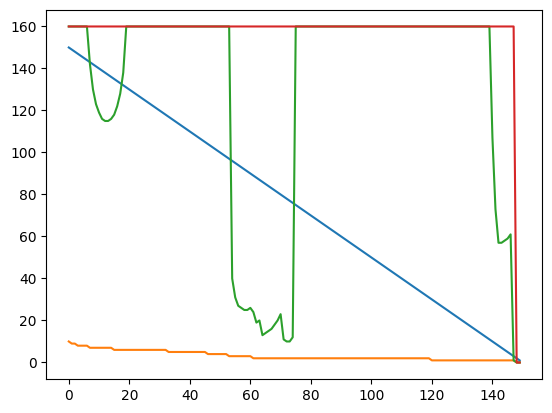

In [62]:
plt.plot(teda.rulR)
plt.plot(teda.rulL)
plt.plot(teda.rulP)
plt.plot(teda.rulU)